In [1]:
#Imports
import pandas as pd
import os
import tensorflow as tf

from scipy.stats import ks_2samp
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

import sys  
sys.path.append("../../")  
from utils.models import *
from utils.datahandling import *
from utils.modelrunner import *

In [2]:
# Define constants and configurations
num_features = 7  # Number of features
sequence_length = 25
batch_size = 16
evaluation_interval = 168
mae_threshold = 0.1
ks_significance_level = 0.05

In [3]:
# Load data
num_users = 30
num_rounds = 5
dataset_name = "PV"

cwd = os.path.normpath(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
df = pd.read_csv(cwd+f'/data/3final_data/Final_{dataset_name}_dataset.csv', index_col='Date')
df.index = pd.to_datetime(df.index)
df.fillna(0, inplace=True)

# Filter data for a specific period
start_date = df.index.min() + pd.DateOffset(years=1)
end_date = df.index.max()
df = df[(df.index >= start_date) & (df.index < end_date)]

df = min_max_scaling(df)
df.reset_index(inplace=True, drop=True)

df_array = []
for idx in range(num_users):
    df_array.append(df[[f'User{idx+1}', 'temp', 'rhum', 'wspd', 'PC1', 'hour sin', 'hour cos', f'User{idx+1}_lag_24hrs']])

In [4]:
loss = tf.keras.losses.MeanSquaredError()
metrics=[
    tf.keras.metrics.RootMeanSquaredError(), 
    tf.keras.metrics.MeanAbsolutePercentageError(),
    tf.keras.metrics.MeanAbsoluteError(),
]

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,mode='min')
timing_callback = TimingCallback()
custom_callback = CustomCallback()

callbacks=[early_stopping, timing_callback, custom_callback]

custom_objects = {'EinsumLayer': EinsumLayer,'TopKLayer': TopKLayer,'ImportanceRegularizationLayer': ImportanceRegularizationLayer}

In [5]:
def load_and_compile_model(model_path, model_type, custom_objects=None):
    model = tf.keras.models.load_model(model_path, custom_objects=custom_objects, compile=False)
    model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=metrics)
    return model

def calculate_metrics(actual, predictions):
    return {
        'RMSE': np.sqrt(mean_squared_error(actual, predictions)),
        'MAE': mean_absolute_error(actual, predictions),
        'MSE': mean_squared_error(actual, predictions)
    }

def check_concept_drift(actual_interval, predicted_interval, previous_mae, mae_threshold, ks_significance_level, cd_mae_counter, cd_ks_counter):
   
    current_mae = mean_absolute_error(actual_interval, predicted_interval)
    
    if not np.isnan(previous_mae) and current_mae > previous_mae * (1 + mae_threshold):
        cd_mae_counter += 1

    ks_pvalue = ks_2samp(actual_interval, predicted_interval).pvalue
    if ks_pvalue < ks_significance_level:
        cd_ks_counter += 1 

    return cd_mae_counter, cd_ks_counter, current_mae

In [6]:
y = np.loadtxt(cwd+'/data/3final_data/Clusters_KMeans10_dtw.csv', delimiter=',').astype(int)
num_clusters = 10
cluster_users = {i: [] for i in range(num_clusters)}

# Iterate through each cluster
for cluster_number in range(num_clusters):
    users_in_cluster = np.where(y == cluster_number)[0] +1
    cluster_users[cluster_number] = users_in_cluster
cluster_users

{0: array([ 7, 14, 18, 22, 23, 25, 29], dtype=int64),
 1: array([6], dtype=int64),
 2: array([ 3,  4,  9, 13, 15, 19, 20, 30], dtype=int64),
 3: array([1], dtype=int64),
 4: array([21], dtype=int64),
 5: array([ 2, 28], dtype=int64),
 6: array([ 5, 10, 11, 12, 24, 26, 27], dtype=int64),
 7: array([8], dtype=int64),
 8: array([17], dtype=int64),
 9: array([16], dtype=int64)}

In [7]:
# Initialize DataFrame to store results
columns = ['User', 'Round', 'CD_mae_count', 'CD_ks_count']
model_names = ['BiLSTM', 'CNN', 'Transformer', 'soft_dense', 'soft_bilstm', 'topk_dense', 'topk_bilstm']

for name in model_names:
    columns.extend([f'RMSE_{name}', f'MAE_{name}', f'MSE_{name}'])

results_df = pd.DataFrame(columns=columns) 

stream_predictions = {round: {cluster_number: {user_index: {name: [] for name in model_names} for user_index in users_in_cluster} 
                   for cluster_number, users_in_cluster in cluster_users.items()} for round in range(num_rounds)}

#For validation performe multiple rounds
for round in range(num_rounds):

    # Iterate through the users within a cluster
    for cluster_number, users_in_cluster in cluster_users.items():
        
        #Load and compile the 7 models for the current cluster
        model_paths = {
            'BiLSTM': f'{cwd}/src/time_series/Federatedlearning/TS_FL_{dataset_name}_Forecasting_Benchmark/wandb/TS_FL_{dataset_name}_global_bilstm_c{cluster_number}_FLround{3}.keras',
            'CNN': f'{cwd}/src/time_series/Federatedlearning/TS_FL_{dataset_name}_Forecasting_Benchmark/wandb/TS_FL_{dataset_name}_global_cnn_c{cluster_number}_FLround{3}.keras',
            'Transformer': f'{cwd}/src/time_series/Federatedlearning/TS_FL_{dataset_name}_Forecasting_Benchmark/wandb/TS_FL_{dataset_name}_global_transformer_c{cluster_number}_FLround{3}.keras',
            'soft_bilstm': f'{cwd}/src/time_series/Federatedlearning/TS_FL_{dataset_name}_Forecasting_Moe/wandb/TS_FL_{dataset_name}_global_soft_bilstm_c{cluster_number}_FLround{3}.keras',
            'soft_dense': f'{cwd}/src/time_series/Federatedlearning/TS_FL_{dataset_name}_Forecasting_Moe/wandb/TS_FL_{dataset_name}_global_soft_dense_c{cluster_number}_FLround{3}.keras',
            'topk_bilstm': f'{cwd}/src/time_series/Federatedlearning/TS_FL_{dataset_name}_Forecasting_Moe/wandb/TS_FL_{dataset_name}_global_topk_bilstm_c{cluster_number}_FLround{3}.keras',
            'topk_dense': f'{cwd}/src/time_series/Federatedlearning/TS_FL_{dataset_name}_Forecasting_Moe/wandb/TS_FL_{dataset_name}_global_topk_dense_c{cluster_number}_FLround{3}.keras'
        }
        models = {name: load_and_compile_model(path, name, custom_objects) for name, path in model_paths.items()}
        
        #For each user in the cluster performe predictions
        for user_index in users_in_cluster:
            
            print("Round ", round+1, " / ", num_rounds, " - User ", user_index, " in cluster ", cluster_number)
            
            # Stream data simulation, initialization
            user_df = df_array[user_index-1].copy()
            stream_data = user_df.values
            stream_buffer = []
            actual_values = []
            cd_mae_counter, cd_ks_counter = 0,0
            previous_mae_bilstm = np.NaN
        
            # Enumerate through the data stream
            for idx, data in enumerate(stream_data):
                
                # Buffer: Append data (1 row is one array) to the buffer and pop oldest if sequence_length is surpassed.
                stream_buffer.append(data)
                
                # Check if we have enough data for a batch prediction
                if len(stream_buffer) >= batch_size + sequence_length - 1:
                    # Prepare batch data for prediction
                    batch_data = []
                    for i in range(batch_size):
                        x_pred = np.array([stream_buffer[i:i+sequence_length-1]])
                        batch_data.append(x_pred)              
                    
                    # Convert list to numpy array for prediction
                    batch_data = np.concatenate(batch_data, axis=0)  # Shape becomes (16, 24, 8)

                    # Make predictions for each model
                    for name, model in models.items():
                        predictions = model.predict(batch_data, callbacks=callbacks, verbose=0)
                        stream_predictions[round][cluster_number][user_index][name].extend(predictions[:, 0].tolist())

                    # Append actual values for the batch
                    actual_values.extend([d[0] for d in stream_buffer[-batch_size:]])
                    # Clear the processed batch data from buffer
                    del stream_buffer[:batch_size]

                # Check and evaluate at every evaluation_interval
                if (idx + 1) % evaluation_interval == 0 and len(actual_values) >= evaluation_interval:
                    actual_interval = actual_values[-evaluation_interval:]
                    predicted_interval = stream_predictions[round][cluster_number][user_index]['BiLSTM'][-evaluation_interval:]  # Example for BiLSTM

                    cd_mae_counter, cd_ks_counter, current_mae = check_concept_drift(
                        actual_interval, predicted_interval, previous_mae_bilstm, mae_threshold, ks_significance_level, cd_mae_counter, cd_ks_counter
                    )
                                    
                    previous_mae_bilstm = current_mae   
                    
            # Calculate metrics for each model and append to DataFrame
            if actual_values:
                metrics_data = {'User': user_index+1, 'Round': round+1, 'CD_mae_count': cd_mae_counter, 'CD_ks_count': cd_ks_counter}
                for name in model_names:
                    metrics_data.update({f'{metric}_{name}': value for metric, value in calculate_metrics(actual_values, stream_predictions[round][cluster_number][user_index][name]).items()})
                results_df.loc[len(results_df)] = metrics_data
            
    results_df

Round  1  /  5  - User  7  in cluster  0
Round  1  /  5  - User  14  in cluster  0
Round  1  /  5  - User  18  in cluster  0
Round  1  /  5  - User  22  in cluster  0
Round  1  /  5  - User  23  in cluster  0
Round  1  /  5  - User  25  in cluster  0
Round  1  /  5  - User  29  in cluster  0
Round  1  /  5  - User  6  in cluster  1
Round  1  /  5  - User  3  in cluster  2
Round  1  /  5  - User  4  in cluster  2
Round  1  /  5  - User  9  in cluster  2
Round  1  /  5  - User  13  in cluster  2
Round  1  /  5  - User  15  in cluster  2
Round  1  /  5  - User  19  in cluster  2
Round  1  /  5  - User  20  in cluster  2
Round  1  /  5  - User  30  in cluster  2
Round  1  /  5  - User  1  in cluster  3
Round  1  /  5  - User  21  in cluster  4
Round  1  /  5  - User  2  in cluster  5
Round  1  /  5  - User  28  in cluster  5
Round  1  /  5  - User  5  in cluster  6
Round  1  /  5  - User  10  in cluster  6
Round  1  /  5  - User  11  in cluster  6
Round  1  /  5  - User  12  in cluster  6


In [8]:
predictions_df = pd.DataFrame.from_dict(stream_predictions)

predictions_df.to_csv(f'results/Predictions_DS_FL_{dataset_name}_Forecasting.csv')  
results_df.to_csv(f'results/Results_DS_FL_{dataset_name}_Forecasting.csv')  

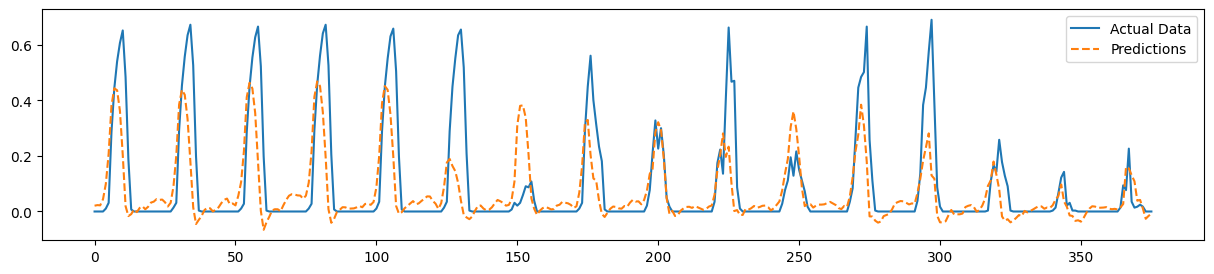

In [9]:
# Plotting to visualize the results
plt.figure(figsize=(15, 3))
plt.plot(df['User1'][124:500].values, label='Actual Data')
plt.plot(stream_predictions[0][9][16]["soft_bilstm"][124:500], label='Predictions', linestyle='dashed')
plt.legend()
plt.show()